In [1159]:
%matplotlib inline
import xmitgcm
import xgcm
import xarray as xr
import matplotlib.pyplot as plt
from xlayers import finegrid, layers
from xlayers.core import layers_apply,layers_numpy
import numpy as np
from MITgcmutils import jmd95
import time as time
import matplotlib.colors as colors
from pathlib import Path
import pandas as pd
from scipy.interpolate import interp1d

In [555]:
#load mitgcm output where \kappa_{redi}=50 (modern)
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer'
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_GMadv_nobvp'
datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer_skewflux_modGMdiagnose'
#iters=[152452800]
iters=[134308848]
prefixes=['Stave','Ttave','vVeltave','uVeltave','wVeltave','DIAG_tracer_adv_diff','PTRtave01','GMflux','Tdiftave','GM_Kwz-T','divergence','GMRediTensor']
dsGM2x=xmitgcm.open_mdsdataset(datadir,prefix=prefixes,iters=iters)
datadirADVForm='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_GMadv_nobvp'
prefixesADVForm=['Stave','Ttave','vVeltave','uVeltave','wVeltave','DIAG_tracer_adv_diff','PTRtave01','GMflux','Tdiftave','GM_Kwz-T','divergence','GM_PsiX','GM_PsiY','GMRediTensor','LaVH1RHO','LaUH1RHO']

dsGM2xADVForm=xmitgcm.open_mdsdataset(datadirADVForm,prefix=prefixesADVForm,iters=iters)
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drF', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(dsGM2x, periodic=['X'], metrics=metrics)
#dsGM2x.assign(GM_Age_r=dsGM2x.GM_Age_r*2)
#dsGM2x.assign(GM_Age_x=dsGM2x.GM_Age_x*2)
#dsGM2x.assign(GM_Age_y=dsGM2x.GM_Age_y*2)
savedir='/Users/boerzhang/Desktop/ocean_project/paper_production_figure/'



In [803]:
class myRun: 
    '''
    packed class for a MITgcm simulation: saving some intermidiate variables,
    and implementing some functions for calculation and plotting.
    The goal is to reduce unnecessary repeat of code for analyzing different simulations
    '''
    def __init__(self,dataset:xr.Dataset,Kgm=500,Kredi=500):
        
        self.ds=dataset
        ## init grid
        metrics = {
            ('X',): ['dxC', 'dxG'], # X distances
            ('Y',): ['dyC', 'dyG'], # Y distances
            ('Z',): ['drF', 'drC'], # Z distances
            ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
        }
        self.grid=xgcm.Grid(self.ds, periodic=['X'], metrics=metrics)
        ## init GM parameters Kuz,Kvy,Kwx,Kwy
        self.calc_GM_parameters(Kgm=Kgm,Kredi=Kredi)  
    '''
    def plotBasinGeometry(self):
        #implemented
        pass
    def plotsst(self):
        #implemented
        pass
    def plotEmP(self):
        #not implemented
        pass
    def rhoinit(self,layers1_bounds=layers1_bounds,rhoConst=1035,use_pd=True,refPres=2000):
        pass
    ''' 
    def calc_GM_parameters(self,Kgm=500,Kredi=500,modifiedGMTensor=True):
        '''
        calculating 4 GM parameters (Kuz,Kvy,Kwx,Kwy) from model diagnostics (separating Redi term)
        '''       
        #modifiedGMTensor=True
        if modifiedGMTensor is True:
            #Kgm=1000
            #Kredi=500
            self.GM_Kuz_gm=-self.ds.GM_Kuz.mean('time')*Kgm
            self.GM_Kvy_gm=-self.ds.GM_Kvy.mean('time')*Kgm
            self.GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm
            self.GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm

        else:
            raise ValueError("Not implemented")
            Kgm=1000
            Kredi=500
            GM_Kuz_gm=dsGM2x.GM_Kuz.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kvy_gm=dsGM2x.GM_Kvy.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kwx_gm=dsGM2x.GM_Kwx.mean('time')*Kgm/(Kgm+Kredi)
            GM_Kwy_gm=dsGM2x.GM_Kwy.mean('time')*Kgm/(Kgm+Kredi)
    
      
RunGM2x=myRun(dsGM2x,Kgm=1000,Kredi=500)

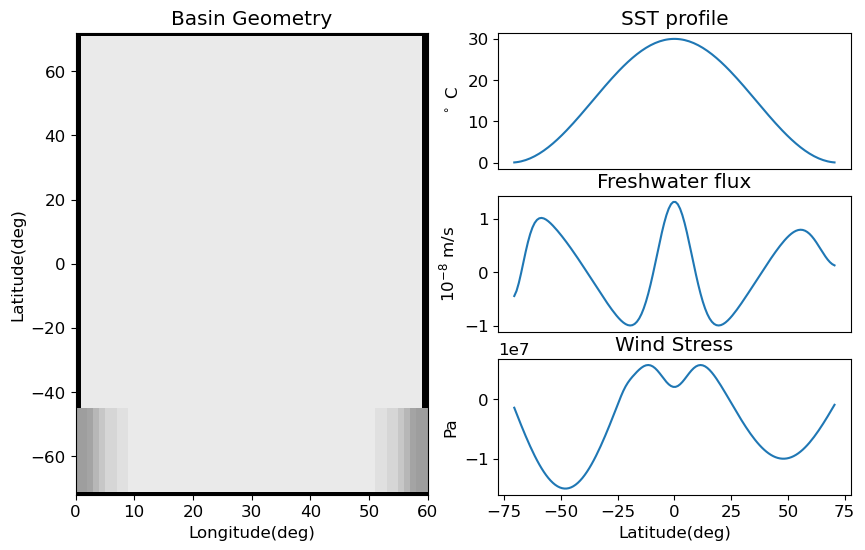

In [794]:
#Figure1
#This function is from stackoverflow https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#make a figure
fig=plt.figure(figsize=(10,6))
plt.rc('font', size=12)
fig.tight_layout()
#plot Basin Geometry
plt.subplot(1,2,1)
def plotBasinGeometry(self):
        cmap=plt.cm.get_cmap('Greys_r',20)
        cmap=truncate_colormap(cmap,0,0.8)
        #cmap.set_over('c')
        self.ds.Depth.plot( cmap=cmap,add_colorbar=False)
        #plt.gca().set_facecolor("grey")
        plt.xlabel('Longitude(deg)')
        plt.ylabel('Latitude(deg)')
        plt.title('Basin Geometry')
myRun.plotBasinGeometry=plotBasinGeometry
RunGM2x.plotBasinGeometry()
#plot sst
plt.subplot(3,2,2)
sstfile=Path(datadir+"/sst_Atlonly.bin")
def plotsst(self,filename=sstfile): 
    sst=0*dsGM2x.Depth
    sst=sst+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
    sst.where(sst!=0).mean('XC').plot(x='YC')
    plt.ylabel('$^\circ$ C')
    #plt.xlabel('Latitude(deg)')
    plt.xlabel('')
    plt.title('SST profile')
    plt.gca().set_xticks([])
myRun.plotsst=plotsst
RunGM2x.plotsst(sstfile)
##plot Emp: not included into the myRun class. Seems not necessary.
plt.subplot(3,2,4)
sstfile=Path(datadir+"/EmP_Atlonly.bin")
EmP=0*dsGM2x.Depth
EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
(-EmP.where(sst!=0).mean('XC')*1e8).plot(x='YC')
plt.ylabel('$10^{-8}$ m/s')
plt.xlabel('')
plt.title('Freshwater flux')
plt.gca().set_xticks([])
#plotsurfacewind
plt.subplot(3,2,6)
sstfile=Path(datadir+"/taux_Atlonly.bin")
EmP=0*dsGM2x.Depth
EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
(-EmP.where(sst!=0).mean('XC')*1e8).plot(x='YC')
plt.ylabel('Pa')
plt.xlabel('Latitude(deg)')
plt.title('Wind Stress')
#plt.gca().set_xticks([])
fig.savefig(Path(savedir+'model_config.pdf'), bbox_inches='tight')

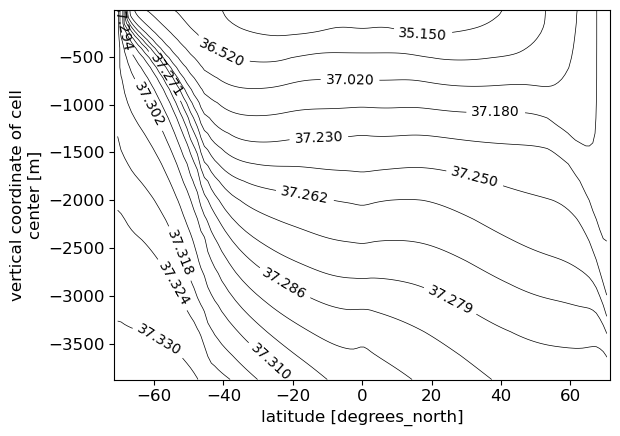

In [805]:

#dealing with potential density/density boundaries
layers1_bounds=[29,
     35.15,
     36.52,
     37.02,
     37.18,
     37.23,
     37.25,
     37.262,
     37.271,
     37.279,
     37.286,
     37.294,
     37.302,
     37.310,
     37.318,
     37.324,
     37.330,
     37.36]

def rhoinit(self,layers1_bounds=layers1_bounds,rhoConst=1035,use_pd=True,refPres=2000):
    '''
    calculate the density surfaces
    use_pd: calculate potential density rather than locally referred
    refPres: reference pressure for potential density in dbar
    '''
    
    Stave=self.ds.Stave.mean('time')
    Ttave=self.ds.Ttave.mean('time')
    
    Stave=Stave.where(Stave!=0)
    if use_pd:
        rho3D=jmd95.densjmd95(Stave,Ttave,refPres)    
    else:
        locPres3D=self.ds.locPres.broadcast_like(Stave)
        locPres=self.ds.PHrefC*rhoConst
        rho3D=jmd95.densjmd95(Stave,Ttave,locPres3D/10000)
    self.rho3D=0*Stave+rho3D
    #is it reasonable to put layers1_bounds into the class? Jan8,2023
    self.layers1_bounds=layers1_bounds
    
    
    #def rhoidinit(self):
    '''
    calculate rhoindex based on rho3D data and layers1_bounds
    There used to be a helper function but is removed now
    '''
    self.Nlayersbin=len(self.layers1_bounds)
    rhoindex=0*self.rho3D.load().data
    rho3Ddata=self.rho3D.load().data
    [Nz,Ny,Nx]=rhoindex.shape

    #layers1_bounds: boundary of layers, index 1:N (or 0:N-1 in python)
    #rhoindex:index for rho at the center of layers1_bounds index 1:N-1 (or 0:N-2 in python)

    for idx in range(Nx):
        for idy in range(Ny):     
            for idz in range(Nz):
                rhotemp=rho3Ddata[idz,idy,idx]-1000
                #print(rhotemp.load())
                if np.isnan(rhotemp):
                    rhoindex[idz,idy,idx]=np.nan
                    continue
                #rhoid_currentgrid=0
                for idrho in range(1,Nlayersbin):
                    rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]

                    if rhotemp<layers1_bounds[idrho]:
                        break
                #print(rhoid_currentgrid)
                rhoindex[idz,idy,idx]=rhoid_currentgrid
    self.rhoindex=rhoindex
    

myRun.rhoinit=rhoinit
RunGM2x.rhoinit(layers1_bounds)

def plot_rhocontours(self):
    '''
    plotting rho contours for myRun class
    '''
    CS=(self.rho3D-1000).mean('XC').plot.contour(levels=self.layers1_bounds,linewidths=0.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_rhocontours=plot_rhocontours
RunGM2x.plot_rhocontours()


In [807]:
#This cell: calculating diapycnal total age fluxes
#plot diapycnal fluxes

def kappainit(self,nxkappa=1):
    '''
    Initialize kappa 
    nxkappa: kappa times n (for 2xkappa run)
    '''
    #BryanLewis kappa profile
    diffKrBL79surf=2e-5;
    diffKrBL79deep= 1e-4;
    diffKrBL79Ho  = -2000;
    diffKrBL79scl = 150;
    #A hack to broadcast Zl to 3D
    Z3d=0*self.ds.maskC+self.ds.Zl
    kdia3d=diffKrBL79surf+(diffKrBL79deep-diffKrBL79surf)*(np.arctan(-(Z3d-diffKrBL79Ho)/diffKrBL79scl)/np.pi+0.5 );
    self.kdia3d=nxkappa*kdia3d

myRun.kappainit=kappainit
RunGM2x.kappainit(nxkappa=1)
    

def FluxDivCalc(self):
    #Tdiftave code is modified to output kdia+GM_Kwz+kconv, credit to: Shantong Sun
    kappa=self.ds.Tdiftave.mean('time') #kappa=kdia+GM_kwz+kconv
    #GM_Kwz
    GM_Kwz=self.ds['GM_Kwz-T'].mean('time')
    #fractions of different fluxes
    frac_dia=kdia3d/kappa
    frac_GM_Kwz=GM_Kwz/kappa
    frac_conv=1-frac_dia-frac_GM_Kwz
    #different fluxes (could potentially be written as a function of dataset)
    fadvx=self.ds.ADVxTr01.mean('time')
    fdiffx=self.ds.DFxETr01.mean('time') #GM-Redi x age flux
    fadvy=self.ds.ADVyTr01.mean('time')
    fdiffy=self.ds.DFyETr01.mean('time') #GM-Redi y age flux
    fadvr=self.ds.ADVrTr01.mean('time')
    fdiffrE=self.ds.DFrETr01.mean('time') #GM-Redi z age flux: contribution of Kwx and Kwy
    fdiffrI=self.ds.DFrITr01.mean('time') #contribution of kdia+GM_Kwz+kconv
    #GM age flux
    fGMx=2*self.ds.GM_Age_x.mean('time')
    fGMy=2*self.ds.GM_Age_y.mean('time')
    fGMr=2*self.ds.GM_Age_r.mean('time') #only contribution of Kwx and Kwy, but this is already total GMr flux since Kwz_GM=0
    #Redi age flux
    fRedix=fdiffx-fGMx
    fRediy=fdiffy-fGMy
    fRedirE=fdiffrE-fGMr
    #separating implicit diffusion: kdia+GM_Kwz+kconv
    fRedirI=fdiffrI*frac_GM_Kwz #only Redi diffusion has contribution in GM-Redi tensor GM_Kwz (no GM contribution)
    fdia=fdiffrI*frac_dia
    fconv=fdiffrI*frac_conv
    #Redi r term
    fRedir=fRedirE+fRedirI
    #total age flux
    ftotx=fadvx+fdiffx
    ftoty=fadvy+fdiffy
    ftotr=fadvr+fdiffrE+fdiffrI
    fsurf=self.ds.ForcTr01.mean('time')*self.ds.rA*self.ds.drF
    fsurf[1:,:,:]=0
    Vol=self.ds.rA*self.ds.drF
    '''
    for varname in ['ftot','fRedi','fGM']:
        exec(f"self.{varname}x={varname}x")
        exec(f"self.{varname}y={varname}y")
        exec(f"self.{varname}r={varname}r")
    '''
    
    def divflux(fx,fy,fr,grid=self.grid):
        '''
        return divergence of a certain flux F(fx,fy,fz)
        '''
        divfx=grid.diff(fx,axis='X',boundary='periodic')
        divfy=grid.diff(fy,axis='Y',boundary='periodic')
        divfr=-grid.diff(fr,axis='Z',boundary='periodic')
        return divfx,divfy,divfr,divfx+divfy+divfr

    #div tot flux
    divtotx,divtoty,divtotr,divtot=divflux(ftotx,ftoty,ftotr)
    #div ADV flux: be careful on boundary condition, especially for diffusive fluxes
    divadvx,divadvy,divadvr,divadv=divflux(fadvx,fadvy,fadvr)
    #div GM flux
    divGMx,divGMy,divGMr,divGM=divflux(fGMx,fGMy,fGMr)
    #div Redi flux
    divRedix,divRediy,divRedir,divRedi=divflux(fRedix,fRediy,fRedir)
    #div dia flux
    divdia=-self.grid.diff(fdia,axis='Z',boundary='periodic')
    #div conv flux
    divconv=-self.grid.diff(fconv,axis='Z',boundary='periodic')
    #Volume
    Voldata=Vol.transpose('Z','YC','XC').load().data
    
    def rhoInt(Xdata,rhoindex=self.rhoindex,Nlayersbin=self.Nlayersbin):
        ''''''
        'Integrate Xdata at density layers'
        ''''''
        dX_rho=np.zeros([Nlayersbin-1,1])
        for idx in range(Nx):
            for idy in range(Ny):
                for idz in range(Nz): 
                    rhoindextemp=rhoindex[idz,idy,idx]
                    if(~np.isnan(rhoindextemp)):  
                        dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
        return np.cumsum(dX_rho[::-1])[::-1]


    self.sumVol_rho=rhoInt(Voldata)
    #sumdivtoty_rho=rhoInt(divtoty.load().data)
    #sumdivtotx_rho=rhoInt(divtotx.load().data)
    #sumdivtotr_rho=rhoInt(divtotr.load().data)
    #sumdivtot_rho=sumdivtotx_rho+sumdivtoty_rho+sumdivtotr_rho
    self.sumdivtot_rho=rhoInt(divtot.load().data)
    #sumdivtotydiag_rho=rhoInt(divtoty_diag.load().data)
    self.sumdivadv_rho=rhoInt(divadv.load().data)
    self.sumdivGM_rho=rhoInt(divGM.load().data)
    self.sumdivRedi_rho=rhoInt(divRedi.load().data)
    self.sumdivconv_rho=rhoInt(divconv.load().data)
    self.sumdivdia_rho=rhoInt(divdia.load().data)
    self.sumfsurf_rho=rhoInt(fsurf.load().data)
    
myRun.FluxDivCalc=FluxDivCalc
RunGM2x.FluxDivCalc()



<function myRun.__dir__()>

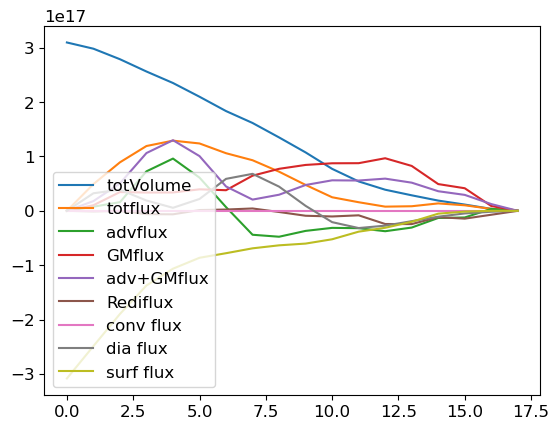

In [829]:
#This cell: calculating diapycnal total age fluxes
#plot diapycnal fluxes

def kappainit(self,nxkappa=1):
    '''
    Initialize kappa 
    nxkappa: kappa times n (for 2xkappa run)
    '''
    #BryanLewis kappa profile
    diffKrBL79surf=2e-5;
    diffKrBL79deep= 1e-4;
    diffKrBL79Ho  = -2000;
    diffKrBL79scl = 150;
    #A hack to broadcast Zl to 3D
    Z3d=0*self.ds.maskC+self.ds.Zl
    kdia3d=diffKrBL79surf+(diffKrBL79deep-diffKrBL79surf)*(np.arctan(-(Z3d-diffKrBL79Ho)/diffKrBL79scl)/np.pi+0.5 );
    self.kdia3d=nxkappa*kdia3d

myRun.kappainit=kappainit
RunGM2x.kappainit(nxkappa=1)
    

def FluxDivCalc(self):
    #Tdiftave code is modified to output kdia+GM_Kwz+kconv, credit to: Shantong Sun
    kappa=self.ds.Tdiftave.mean('time') #kappa=kdia+GM_kwz+kconv
    #GM_Kwz
    GM_Kwz=self.ds['GM_Kwz-T'].mean('time')
    #fractions of different fluxes
    frac_dia=kdia3d/kappa
    frac_GM_Kwz=GM_Kwz/kappa
    frac_conv=1-frac_dia-frac_GM_Kwz
    #different fluxes (could potentially be written as a function of dataset)
    fadvx=self.ds.ADVxTr01.mean('time')
    fdiffx=self.ds.DFxETr01.mean('time') #GM-Redi x age flux
    fadvy=self.ds.ADVyTr01.mean('time')
    fdiffy=self.ds.DFyETr01.mean('time') #GM-Redi y age flux
    fadvr=self.ds.ADVrTr01.mean('time')
    fdiffrE=self.ds.DFrETr01.mean('time') #GM-Redi z age flux: contribution of Kwx and Kwy
    fdiffrI=self.ds.DFrITr01.mean('time') #contribution of kdia+GM_Kwz+kconv
    #GM age flux
    fGMx=2*self.ds.GM_Age_x.mean('time')
    fGMy=2*self.ds.GM_Age_y.mean('time')
    fGMr=2*self.ds.GM_Age_r.mean('time') #only contribution of Kwx and Kwy, but this is already total GMr flux since Kwz_GM=0
    #Redi age flux
    fRedix=fdiffx-fGMx
    fRediy=fdiffy-fGMy
    fRedirE=fdiffrE-fGMr
    #separating implicit diffusion: kdia+GM_Kwz+kconv
    fRedirI=fdiffrI*frac_GM_Kwz #only Redi diffusion has contribution in GM-Redi tensor GM_Kwz (no GM contribution)
    fdia=fdiffrI*frac_dia
    fconv=fdiffrI*frac_conv
    #Redi r term
    fRedir=fRedirE+fRedirI
    #total age flux
    ftotx=fadvx+fdiffx
    ftoty=fadvy+fdiffy
    ftotr=fadvr+fdiffrE+fdiffrI
    fsurf=self.ds.ForcTr01.mean('time')*self.ds.rA*self.ds.drF
    fsurf[1:,:,:]=0
    Vol=self.ds.rA*self.ds.drF
    '''
    for varname in ['ftot','fRedi','fGM']:
        exec(f"self.{varname}x={varname}x")
        exec(f"self.{varname}y={varname}y")
        exec(f"self.{varname}r={varname}r")
    '''
    
    def divflux(fx,fy,fr,grid=self.grid):
        '''
        return divergence of a certain flux F(fx,fy,fz)
        '''
        divfx=grid.diff(fx,axis='X',boundary='periodic')
        divfy=grid.diff(fy,axis='Y',boundary='periodic')
        divfr=-grid.diff(fr,axis='Z',boundary='periodic')
        return divfx,divfy,divfr,divfx+divfy+divfr

    #div tot flux
    divtotx,divtoty,divtotr,divtot=divflux(ftotx,ftoty,ftotr)
    #div ADV flux: be careful on boundary condition, especially for diffusive fluxes
    divadvx,divadvy,divadvr,divadv=divflux(fadvx,fadvy,fadvr)
    #div GM flux
    divGMx,divGMy,divGMr,divGM=divflux(fGMx,fGMy,fGMr)
    #div Redi flux
    divRedix,divRediy,divRedir,divRedi=divflux(fRedix,fRediy,fRedir)
    #div dia flux
    divdia=-self.grid.diff(fdia,axis='Z',boundary='periodic')
    #div conv flux
    divconv=-self.grid.diff(fconv,axis='Z',boundary='periodic')
    #Volume
    Voldata=Vol.transpose('Z','YC','XC').load().data
    
    def rhoInt(Xdata,rhoindex=self.rhoindex,Nlayersbin=self.Nlayersbin):
        ''''''
        'Integrate Xdata at density layers'
        ''''''
        dX_rho=np.zeros([Nlayersbin,1])
        for idx in range(Nx):
            for idy in range(Ny):
                for idz in range(Nz): 
                    rhoindextemp=rhoindex[idz,idy,idx]
                    if(~np.isnan(rhoindextemp)):  
                        dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
        return np.cumsum(dX_rho[::-1])[::-1]


    self.sumVol_rho=rhoInt(Voldata)
    #sumdivtoty_rho=rhoInt(divtoty.load().data)
    #sumdivtotx_rho=rhoInt(divtotx.load().data)
    #sumdivtotr_rho=rhoInt(divtotr.load().data)
    #sumdivtot_rho=sumdivtotx_rho+sumdivtoty_rho+sumdivtotr_rho
    self.sumdivtot_rho=rhoInt(divtot.load().data)
    #sumdivtotydiag_rho=rhoInt(divtoty_diag.load().data)
    self.sumdivadv_rho=rhoInt(divadv.load().data)
    self.sumdivGM_rho=rhoInt(divGM.load().data)
    self.sumdivRedi_rho=rhoInt(divRedi.load().data)
    self.sumdivconv_rho=rhoInt(divconv.load().data)
    self.sumdivdia_rho=rhoInt(divdia.load().data)
    self.sumfsurf_rho=rhoInt(fsurf.load().data)
    
myRun.FluxDivCalc=FluxDivCalc
RunGM2x.FluxDivCalc()



def plot_diapycnal_flux_on_rhoid(self):
    ##plotting volume/age fluxes at different layer ids 
    #plt.figure()
    plt.plot(self.sumVol_rho,label='totVolume')
    plt.plot(self.sumdivtot_rho,label='totflux')
    plt.plot(self.sumdivadv_rho,label='advflux')
    plt.plot(self.sumdivGM_rho,label='GMflux')
    plt.plot(self.sumdivadv_rho+self.sumdivGM_rho,label='adv+GMflux')
    plt.plot(self.sumdivRedi_rho,label='Rediflux')
    plt.plot(self.sumdivconv_rho,label='conv flux')
    plt.plot(self.sumdivdia_rho,label='dia flux')
    plt.plot(self.sumfsurf_rho,label='surf flux')
    plt.legend()
myRun.plot_diapycnal_flux_on_rhoid=plot_diapycnal_flux_on_rhoid
RunGM2x.plot_diapycnal_flux_on_rhoid()

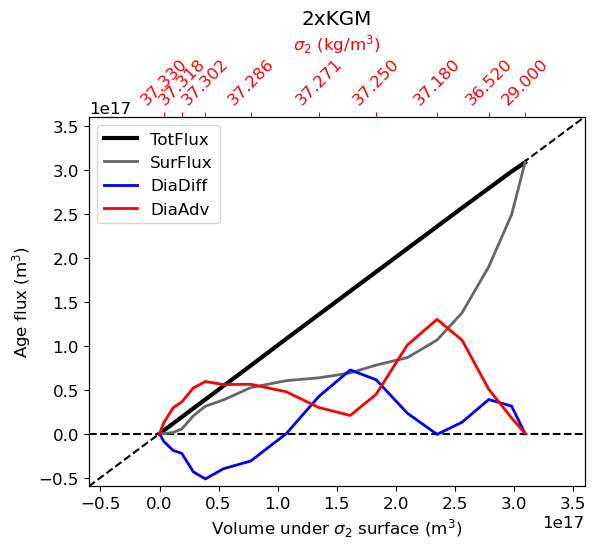

In [883]:

def plot_diapycnal_flux_on_Volume(self,detailed=True):
    #plt.figure()
    lower_bound=-0.6e17
    plt.plot([lower_bound,3.6e17],[lower_bound,3.6e17],'k--')
    plt.plot([lower_bound,3.6e17],[0,0],'k--')
    plt.plot(self.sumVol_rho,self.sumdivtot_rho-self.sumfsurf_rho,'k-',linewidth=3,label='TotFlux')
    plt.plot(self.sumVol_rho,-self.sumfsurf_rho,'-',c='0.4',label='SurFlux',linewidth=2)
    if not detailed:
        plt.plot(self.sumVol_rho,self.sumdivRedi_rho+self.sumdivconv_rho+self.sumdivdia_rho,'b-',label='DiaDiff',linewidth=2)
        plt.plot(self.sumVol_rho,self.sumdivGM_rho+self.sumdivadv_rho,'r-',label='DiaAdv',linewidth=2)
    if detailed:    
        plt.plot(self.sumVol_rho,self.sumdivRedi_rho,'.-',label='Rediflux')
        plt.plot(self.sumVol_rho,self.sumdivGM_rho,'.-',label='GMflux')
        plt.plot(self.sumVol_rho,self.sumdivadv_rho,'.-',label='advflux')
        plt.plot(self.sumVol_rho,self.sumdivGM_rho+self.sumdivadv_rho,'.-',label='adv+GM flux')
        plt.plot(self.sumVol_rho,self.sumdivconv_rho,'.-',label='conv flux')
        plt.plot(self.sumVol_rho,self.sumdivdia_rho,'.-',label='dia flux')
        
    ax1=plt.gca()
    ax2=ax1.twiny()
    ax1.autoscale(enable=True, axis='both', tight=True)
    ax1.set_xlabel('Volume under $\sigma_2$ surface (m$^3$)')
    ax1.set_ylabel('Age flux (m$^3$)')
    ax1.legend()
    ax2.set_xlim(ax1.get_xlim())
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
    ax2.set_xticks(self.sumVol_rho[::2])
    ax2.set_xticklabels([f"{x:.3f}" for x in layers1_bounds[::2]],rotation=45)
    ax2.set_xlabel("$\sigma_2$ (kg/m$^3$)")
    plt.title('2xKGM')

myRun.plot_diapycnal_flux_on_Volume=plot_diapycnal_flux_on_Volume
plt.figure()
RunGM2x.plot_diapycnal_flux_on_Volume(detailed=False)


In [561]:
diaRedi=diaFluxOnRho_3D(fx=fRedix.load().data,fy=fRediy.load().data,fz=fRedir.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvEufluxrhotemp=diaRedi.copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
'''
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e15,0.5e15,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('Redi diapycnal age flux')


'\nfig = plt.figure(figsize=(16,6))\nfor i in range(0,Nlayersbin-1):\n    plt.subplot(3,5, i+1)\n    #dsGM2x.ADVrTr01.isel(Zl=i).mean(\'time\').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))\n    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean(\'time\').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend=\'both\')\n    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean(\'time\').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend=\'both\')\n    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e15,0.5e15,100),cmap=\'seismic\',extend=\'both\')\n    plt.colorbar(format="%.2e")\n    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")\n    plt.xlabel(\'\')\n    plt.ylabel(\'\')\n    plt.gca().set_facecolor("grey") \nfig.subplots_adjust(wspace=0.3,hspace=0.3)\nfig.suptitle(\'Redi diapycnal age flux\')\n'

In [559]:
## interpolating

rhoindex0=rhoindex
[nz,ny,nx]=rhoindex0.shape
rhoindext=rhoindex0[np.r_[0,0:nz-1],:,:]
rhoindexs=rhoindex0[:,np.r_[0,0:ny-1],:]
rhoindexn=rhoindex0[:,np.r_[1:ny,ny-1],:]
rhoindexw=rhoindex0[:,:,np.r_[nx-1,0:nx-1]]
rhoindexe=rhoindex0[:,:,np.r_[1:nx,0]]
rhoindexe
def diaFluxOnRho(fx,fy,fz,rhoindex0,rhoidcur):
  
    MSK_rhot=np.logical_and(rhoindex0>=rhoidcur,rhoindext<rhoidcur)
    MSK_rhow=np.logical_and(rhoindex0>=rhoidcur,rhoindexw<rhoidcur)
    MSK_rhoe=np.logical_and(rhoindex0>=rhoidcur,rhoindexe<rhoidcur)
    MSK_rhos=np.logical_and(rhoindex0>=rhoidcur,rhoindexs<rhoidcur)
    MSK_rhon=np.logical_and(rhoindex0>=rhoidcur,rhoindexn<rhoidcur)
    fxw=fx
    fxe=fx[:,:,np.r_[1:nx,0]]
    fys=fy
    fyn=fy[:,np.r_[1:ny,ny-1],:]
    fluxgrid=(-fxw)*(MSK_rhow)+fxe*(MSK_rhoe)+fyn*(MSK_rhon)+(-fys)*(MSK_rhos)+fz*MSK_rhot
    diafluxrho=np.sum(fluxgrid,axis=0)
    return diafluxrho

diafluxrho=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=0)

diafluxrho3D=np.zeros([Nlayersbin-1,ny,nx])
for layerid in range(Nlayersbin-1):
    diafluxrho3D[layerid,:,:]=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=layerid)

diaFluxOnRho_3D=np.vectorize(
    diaFluxOnRho,
    excluded=['fx','fy','fz','rhoindex0'],
    signature='()->(m,n)'
)



In [560]:
maskGMPsiX=grid.interp(grid.interp(dsGM2x.maskC.where(dsGM2x.maskC),'Z'),'X')
maskGMPsiX[0,:,:]=np.nan
maskGMPsiX=maskGMPsiX.fillna(0)
maskGMPsiY=grid.interp(grid.interp(dsGM2x.maskC.where(dsGM2x.maskC),'Z'),'Y')
maskGMPsiY[0,:,:]=np.nan
maskGMPsiY=maskGMPsiY.fillna(0)
maskr=grid.interp(dsGM2x.maskC.astype('double'),'Z')
maskc=dsGM2x.maskC
maskr=maskr.where(maskr>0.5)
maskr=maskr.fillna(0)
PsixGM_Tensor=grid.interp(GM_Kwx_gm*dsGM2x.rA,'X')/dsGM2x.rAw
PsixGM_Tensor=PsixGM_Tensor.where(maskGMPsiX)
PsixGM_Tensor=PsixGM_Tensor.fillna(0)
delPsixGM_Tensor=grid.diff(PsixGM_Tensor,'Z',boundary='fill')
ugmFromTensor=delPsixGM_Tensor/dsGM2x.drF*dsGM2x.hFacW
PsiyGM_Tensor=grid.interp(GM_Kwy_gm*dsGM2x.rA,'Y')/dsGM2x.rAs
PsiyGM_Tensor=PsiyGM_Tensor.where(maskGMPsiY)
PsiyGM_Tensor=PsiyGM_Tensor.fillna(0)
delPsiyGM_Tensor=grid.diff(PsiyGM_Tensor,'Z',boundary='fill')
vgmFromTensor=delPsiyGM_Tensor/dsGM2x.drF*dsGM2x.hFacS
wgmFromTensor=grid.diff(PsixGM_Tensor*dsGM2x.dyG,'X',boundary='periodic')\
    +grid.diff(PsiyGM_Tensor*dsGM2x.dxG,'Y')
wgmFromTensor=wgmFromTensor/dsGM2x.rA
wgmFromTensor=maskr*wgmFromTensor
age=dsGM2x.PTRtave01
age=age.where(dsGM2x.maskC).mean('time')
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
AgerfluxGM=dsGM2x.GM_Age_r.where(dsGM2x.ADVrTr01!=0).mean('time')
wgmFromSkewflux=AgerfluxGM/agel/dsGM2x.rA
wgmAgeFromTensor=agel*wgmFromTensor*dsGM2x.rA
#age at U points(XG)
ageU=grid.interp(age,'X')
AgexfluxGM=dsGM2x.GM_Age_x.where(dsGM2x.ADVxTr01!=0).mean('time')
xA=dsGM2x.dyG*dsGM2x.drF
ugmAgeFromTensor=ageU*ugmFromTensor*xA
ugmFromSkewflux=AgexfluxGM/ageU/xA
#age at V points(YG)
ageV=grid.interp(age,'Y',boundary='fill')
AgeyfluxGM=dsGM2x.GM_Age_y.where(dsGM2x.ADVyTr01!=0).mean('time')
yA=dsGM2x.dxG*dsGM2x.drF
vgmAgeFromTensor=ageV*vgmFromTensor*yA
vgmFromSkewflux=AgeyfluxGM/ageV/yA
GM_PsiX_nobvp=dsGM2xADVForm.GM_PsiX.mean('time')
GM_PsiY_nobvp=dsGM2xADVForm.GM_PsiY.mean('time')
ugm_nobvp=grid.diff(GM_PsiX_nobvp,'Z',boundary='fill')/dsGM2x.drF
vgm_nobvp=grid.diff(GM_PsiY_nobvp,'Z',boundary='fill')/dsGM2x.drF
wgm_nobvp=(grid.diff(GM_PsiX_nobvp*dsGM2x.dyG,'X',boundary='periodic')+grid.diff(GM_PsiY_nobvp*dsGM2x.dxG,'Y'))/dsGM2x.rA
fadvxnobvp=dsGM2xADVForm.ADVxTr01.mean('time')
fadvynobvp=dsGM2xADVForm.ADVyTr01.mean('time')
fadvrnobvp=dsGM2xADVForm.ADVrTr01.mean('time')
fVolx_nobvp=(fadvxnobvp/ageU).fillna(0)
fVoly_nobvp=(fadvynobvp/ageV).fillna(0)
fVolr_nobvp=(fadvrnobvp/agel).fillna(0)

fadvxtmp=fadvx#+fGMx
fadvytmp=fadvy#+fGMy
fadvrtmp=fadvr#+fGMr
'''
fVolx=(fadvxtmp/ageU).fillna(0)
fVoly=(fadvytmp/ageV).fillna(0)
fVolr=(fadvrtmp/agel).fillna(0)


fVolx=ugmFromSkewflux.fillna(0)*xA
fVoly=vgmFromSkewflux.fillna(0)*yA
fVolr=wgmFromSkewflux.fillna(0)*dsGM2x.rA
#fVolx=ugm_nobvp*xA.fillna(0)
#fVoly=vgm_nobvp*yA.fillna(0)
#fVolr=wgm_nobvp*dsGM2x.rA.fillna(0)
'''
fVolEux=dsGM2x.uVeltave.mean('time')*xA
fVolEuy=dsGM2x.vVeltave.mean('time')*yA
fVolEur=dsGM2x.wVeltave.mean('time')*dsGM2x.rA
fVolgmx=ugmFromTensor.fillna(0)*xA.fillna(0)
fVolgmy=vgmFromTensor.fillna(0)*yA.fillna(0)
fVolgmr=wgmFromTensor.fillna(0)*dsGM2x.rA.fillna(0)
#fVolx_nobvp=ugm_nobvp*xA
#fVolgmy=vgm_nobvp*yA
#fVolgmr=wgm_nobvp*dsGM2x.rA
fVolx=fVolEux+fVolgmx
fVoly=fVolEuy+fVolgmy
fVolr=fVolEur+fVolgmr
diaageadvEufluxrho=diaFluxOnRho_3D(fx=fadvxtmp.load().data,fy=fadvytmp.load().data,fz=fadvrtmp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaageadvgmfluxrho=diaFluxOnRho_3D(fx=fGMx.load().data,fy=fGMy.load().data,fz=fGMr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaageadvfluxrho=diaageadvEufluxrho+diaageadvgmfluxrho
diaageadv_nobvp=diaFluxOnRho_3D(fx=fadvxnobvp.load().data,fy=fadvynobvp.load().data,fz=fadvrnobvp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))

diaVoladvEufluxrho=diaFluxOnRho_3D(fx=fVolEux.load().data,fy=fVolEuy.load().data,fz=fVolEur.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvgmfluxrho=diaFluxOnRho_3D(fx=fVolgmx.load().data,fy=fVolgmy.load().data,fz=fVolgmr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvfluxrho=diaFluxOnRho_3D(fx=fVolx.load().data,fy=fVoly.load().data,fz=fVolr.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diaVoladvfluxrho=diaVoladvEufluxrho+diaVoladvgmfluxrho
diaVoladvnobvp=diaFluxOnRho_3D(fx=fVolx_nobvp.load().data,fy=fVoly_nobvp.load().data,fz=fVolr_nobvp.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))

diaagerho=diaageadvfluxrho/(diaVoladvfluxrho+1e-10)
diaVoladvfluxrho_hsum=np.sum(np.sum(diaVoladvfluxrho,axis=2),axis=1)
diaagerho_nobvp=diaageadv_nobvp/(diaVoladvnobvp+1e-10)


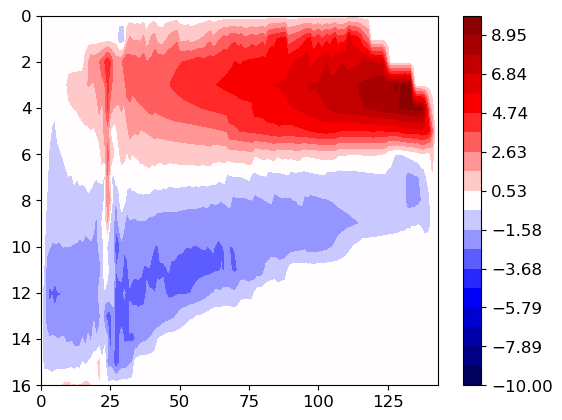

In [562]:
diastreamfunction=np.sum(diaVoladvfluxrho,axis=2)
diastreamfunction=np.cumsum(diastreamfunction,axis=1)
plt.contourf(diastreamfunction/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
plt.colorbar()
plt.gca().invert_yaxis()

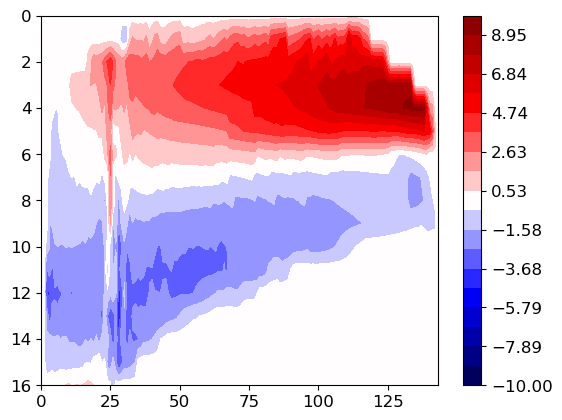

In [563]:
#calculating streamfunction from velocity
#fVoly_nobvp_np=fVoly_nobvp.load().data
#fVoly_nobvp_np=fVolEuy.load().data
fVoly_nobvp_np=(fVolEuy+vgm_nobvp*yA).load().data
#nz=Nlayersbin-1
[nz,ny,nx]=fVolx_nobvp.shape
PsiX_tot_rho=np.zeros([Nlayersbin-1,ny])
for ix in range(nx):
    for iy in range(ny):
        for iz in range(nz):
            rhoidtemp=rhoindex[iz,iy,ix]
            if(np.isnan(rhoidtemp)):
                continue
            #print(rhoidtemp)
            PsiX_tot_rho[int(rhoidtemp),iy]+=fVoly_nobvp_np[iz,iy,ix]
PsiX_tot_rho=np.cumsum(PsiX_tot_rho[::-1,:],axis=0)[::-1,:]
#PsiX_tot_rho=-np.cumsum(PsiX_tot_rho,axis=0)
yy=dsGM2x.YG
zz=layers1_bounds[:-1]
plt.contourf(-PsiX_tot_rho/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
plt.colorbar()
plt.gca().invert_yaxis()

In [564]:
from xlayers import finegrid, layers
from xlayers.core import layers_apply,layers_numpy
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(dsGM2x.drF, dsGM2x.drC,[dsGM2x.drF.size,10])


def layer_tinterp(tracer,maskWi ,mapindex, mapfact):
    
    '''
    interpolating tracer to fine z grid
    '''   
    nzz=len(mapindex)
    tinterp=np.zeros(nzz)
    #print(tinterp)
    for kk in range(nzz):
        #print(kk)
        k=mapindex[kk]-1
        kci=mapindex[kk]
        if(maskWi[k+1]==0):
            kp1=k
        else:
            kp1=k+1
        tinterp[kk]=tracer[k]*mapfact[kk]+tracer[kp1]*(1-mapfact[kk])
    return tinterp

        
    
    
def layer_vinterp(vel,):
    '''
    interpolating velocity to fine z grid
    '''
    nzz=len(mapindex)
    tinterp=np.zeros(nzz)
    #print(tinterp)
    for kk in range(nzz):
        #print(kk)
        k=mapindex[kk]-1
        kci=mapindex[kk]
        if(maskWi[k+1]==0):
            kp1=k
        else:
            kp1=k+1
        tinterp[kk]=tracer[k]*mapfact[kk]+tracer[kp1]*(1-mapfact[kk])
    return tinterp

Ntest=30
tinterp=layer_tinterp(np.arange(Ntest),np.ones(Ntest),mapindex,mapfact)
#tinterp

In [565]:
rhoatV_nonan=rhoatV.copy().load().data
[nz,ny,nx]=rhoatV_nonan.shape
for i in range(nx):
    for j in range(ny):
        rhotemp=0
        for k in range(nz):
            if(np.isnan(rhoatV_nonan[k,j,i])):
                rhoatV_nonan[k,j,i]=rhotemp
            else:
                rhotemp=rhoatV_nonan[k,j,i]
                
rhoatV_nonan=rhoatV.fillna(0)*0+rhoatV_nonan
rhoatV_nonan.load()        

<xarray.DataArray 'Stave' (Z: 30, YG: 144, XC: 60)>
array([[[   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [1037.31915521, 1037.31903261, 1037.31887294, ...,
         1037.31675327, 1037.31870625, 1037.3191158 ],
        ...,
        [   0.        , 1037.24711795, 1037.24406776, ...,
         1037.17020307, 1037.16697852,    0.        ],
        [   0.        , 1037.24908243, 1037.24707647, ...,
         1037.18491249, 1037.18235038,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]],

       [[   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [1037.3191552 , 1037.3190326 , 1037.31887294, ...,
         1037.31675327, 1037.31870624, 1037.31911579],
...
        [   0.        , 1037.27536146, 1037.27549152, ...,
         1037.28330004, 1037.28331726,    0.        ],
        [   0.        , 1037.2742625 , 1037.27434721, ...,
         1037.28334252, 1037.28335637,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]],

       [[   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [1037.3259353 , 1037.32590418, 1037.32675535, ...,
         1037.32724772, 1037.32600233, 1037.32596884],
        ...,
        [   0.        , 1037.28104869, 1037.28109152, ...,
         1037.28349176, 1037.28349429,    0.        ],
        [   0.        , 1037.28079858, 1037.28083821, ...,
         1037.28348693, 1037.28348857,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]]])
Coordinates:
  * XC       (XC) >f4 0.5 1.5 2.5 3.5 4.5 5.5 ... 54.5 55.5 56.5 57.5 58.5 59.5
  * YG       (YG) >f4 -72.0 -71.0 -70.0 -69.0 -68.0 ... 67.0 68.0 69.0 70.0 71.0
  * Z        (Z) >f4 -10.0 -30.0 -50.0 ... -3.375e+03 -3.625e+03 -3.875e+03

In [943]:
dz_layers_atV= layers_apply(dsGM2x.hFacS,(rhoatV_nonan-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
dz_layers_atV= layers_apply(dsGM2x.hFacS,(rhoatV_nonan-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')

# dz_layers_atV_zonalsum is actually the zonal sum of volume water between two layers
# dz_layers_atV_zonalsum:(YG,mylayer_1RHO_bounds)
dz_layers_atV_zonalsum=dz_layers_atV.sum('XC')  

z_layers_atV_zonalsum=dz_layers_atV_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
z_area_below=dsGM2x.drF.where(dsGM2x.hFacS==1).sum('XC').transpose('YG','Z')
z_area_below=z_area_below[:,::-1].cumsum('Z')[:,::-1]

z_depth_np=dsGM2x.Zp1.load().data
z_area_below_np=z_area_below.load().data
[Ny,Nz]=z_area_below_np.shape
z_area_below_np=np.zeros([Ny,Nz+1])
z_area_below_np[:,:-1]=z_area_below

#z_layers_atV_zonalsum
#z_layers_atV_zonalsum.load()

#testdrF=dsGM2x.drF*dsGM2x.hFacS
#testdrF.where(testdrF).mean('XC').sum('Z')
#dz_layers_atV

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


array([225100., 223900., 222700., 221500., 220300., 219100., 217300.,
       214900., 211900., 208300., 203500., 197500., 191500., 185500.,
       178300., 171100., 161500., 151900., 142300., 132700., 123100.,
       111100.,  99100.,  87100.,  73600.,  61000.,  47500.,  34500.,
        22000.,  10500.,      0.])

In [972]:
#print(z_layers_atV_zonalsum[4,:].load())
#print(z_area_below[4,:].load())
z_layers_atV_zonalsum[4,:].load()
z_area_below_np[4,:]
dsGM2x.Zp1
z_layers_atV_zonalsum[4,:].load()

<xarray.DataArray (mylayer_1RHO_bounds: 18)>
array([225099.95780945, 225099.95780945, 225099.95780945, 225099.95780945,
       225099.95780945, 225099.95780945, 221641.62781525, 219240.96181488,
       217178.62857819, 214948.29512405, 212195.29507065, 206674.2947464 ,
       194927.62989807, 169480.6217041 , 130167.95568848,  93304.12225342,
        31941.66204834,      0.        ])
Coordinates:
    YG                   >f4 -68.0
  * mylayer_1RHO_bounds  (mylayer_1RHO_bounds) float64 29.0 35.15 ... 37.36

In [1060]:
z_layers_atV_zonalsum.shape

(144, 18)

sZ: [225100. 223900. 222700. 221500. 220300. 219100. 217300. 214900. 211900.
 208300. 203500. 197500. 191500. 185500. 178300. 171100. 161500. 151900.
 142300. 132700. 123100. 111100.  99100.  87100.  73600.  61000.  47500.
  34500.  22000.  10500.      0.] shape: (31,)
sLayer: [225100.00246429 225100.00246429 216211.34324265 201306.00864029
 189979.34555435 181573.34537125 174834.01150131 168482.67764282
 161750.01042175 153342.67752838 144039.34527588 131073.346138
 115112.01247406  94802.34670258  67621.67812347  44579.17517853
  15327.50198364      0.        ] shape: (18,)
Z: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.] shape: (31,)
[[            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 [-4.28263346e-04 -4.28263346e-04 -4.28263346e-04 ... -2.04367808e+03
  -3.25950020e+03 -4.0000

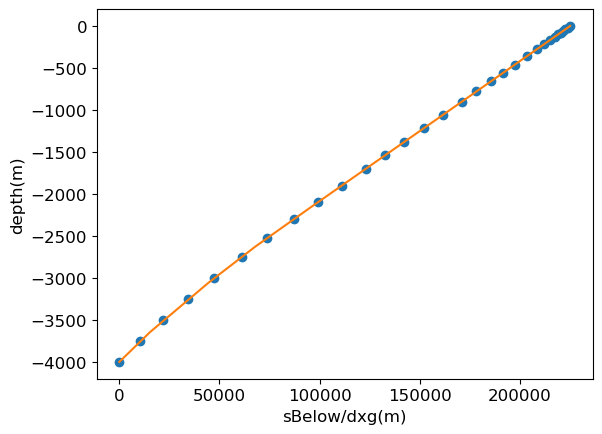

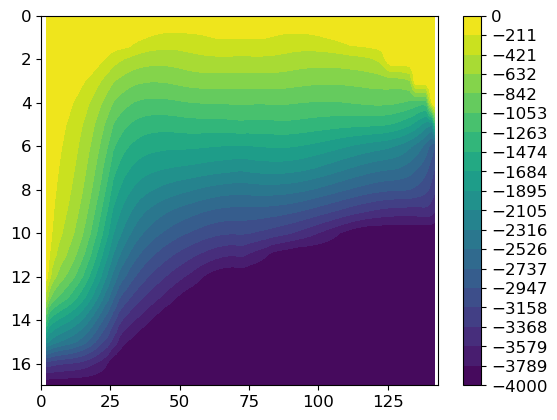

In [1104]:


def layer_depth_interp_1d(sLayer,sZ,Z):
    '''
    Calculating the mean depth of density layer sigma
    sLayer: area below (density) Layer sigma
    sZ: area below depth Z
    Z: depth Z
    '''
    
    #if(sLayer[0]==0):
        ##a dirty hack to remove basin edges (on northern/southern end)
        #return np.nan*sLayer
    #coeff1=np.polyfit(sZ,Z,40)
    #eqfit=np.poly1d(coeff1)
    #ZLayer=eqfit(sLayer)
    fnew=interp1d(sZ,Z,fill_value="extrapolate")
    ZLayer=fnew(sLayer)
    return ZLayer
def layer_depth_interp_mat(sLayer_mat,sZ_mat,Z):
    '''
    Calculating the mean depth of density layer sigma
    sLayer_mat: an array of sLayer
    sZ_mat: an array of sZ
    Z: depth Z
    '''
    [Ny,Nlayer]=sLayer_mat.shape
    Zlayer_mat=np.zeros([Ny,Nlayer])
    for iy in range(Ny):
        #print("iy:",iy)
        Zlayer_mat[iy,:]=layer_depth_interp_1d(sLayer_mat[iy,:],sZ_mat[iy,:],Z,)
    Zlayer_mat[Zlayer_mat>0]=0
    Zlayer_mat[Zlayer_mat<-4000]=-4000
    return Zlayer_mat
    
    
sZ=z_area_below_np[21,:]

Z=dsGM2x.Zp1
#print(type(0*np.zeros(31)))
sLayer=z_layers_atV_zonalsum[21,:].load().data
print("sZ:",sZ,"shape:",sZ.shape)
print("sLayer:",sLayer,"shape:",sLayer.shape)
plt.plot(sZ,Z,'o')
plt.plot(sLayer,layer_depth_interp_1d(sLayer,sZ,Z.load().data))
plt.xlabel('sBelow/dxg(m)')
plt.ylabel('depth(m)')

print("Z:",0*Z.data+1,"shape:",Z.shape)

#print("ZLayer:",interp1d(sZ,Z*0)(sLayer))
#print(0*Z.data)
layer_depth=layer_depth_interp_mat(z_layers_atV_zonalsum.load().data,z_area_below_np,dsGM2x.Zp1)
plt.figure()
plt.contourf(layer_depth.T,vmax=0,vmin=-4000,levels=np.linspace(-4000,0,20))
plt.colorbar(ticks=np.linspace(-4000,0,20))
plt.gca().invert_yaxis()
#print(layer_depth)
#pd.set_option('display.max_rows', 200)
#df=pd.DataFrame(layer_depth)


In [1158]:
def draw_streamfunc(self):
    # interpolating rho to u/v grids
    rhoatV=self.grid.interp(self.rho3D,'Y')
    rhoatU=self.grid.interp(self.rho3D,'X')
    #Volume flux in x/y direction
    tmpfVoly=self.fVolEuy+self.fVolgmy
    tmpfVolx=self.fVolEux+self.fVolgmx
    #nonan here means???
    ##############################################
    #This block below interpolates the data below the bottom of the ocean,
    #to avoid strange behavior of density interpolation
    ##############################################
    rhoatV_nonan=rhoatV.copy().load().data
    rhoatU_nonan=rhoatU.copy().load().data
    rho_nonan=rho3D.copy().load().data
    [nz,ny,nx]=rhoatV_nonan.shape
    for i in range(nx):
        for j in range(ny):
            rhotempV=0
            rhotempU=0
            rhotemp0=0
            for k in range(nz):
                if(np.isnan(rhoatV_nonan[k,j,i])):
                    rhoatV_nonan[k,j,i]=rhotempV
                else:
                    rhotempV=rhoatV_nonan[k,j,i]
                if(np.isnan(rhoatU_nonan[k,j,i])):
                    rhoatU_nonan[k,j,i]=rhotempU
                else:
                    rhotempU=rhoatU_nonan[k,j,i]
                if(np.isnan(rho_nonan[k,j,i])):
                    rho_nonan[k,j,i]=rhotemp0
                else:
                    rhotemp0=rho_nonan[k,j,i]
    ###############################################                

    rhoatV_nonan=rhoatV.fillna(0)*0+rhoatV_nonan
    rhoatU_nonan=rhoatU.fillna(0)*0+rhoatU_nonan
    rho_nonan=rho3D.fillna(0)*0+rho_nonan
    ###############################################
    layers1_bounds_streamfunc=np.linspace(29,37.4,1000)
    #layers1_bounds=dsGM2xADVForm.layer_1RHO_bounds.load().data
    dPsiY_layers= layers_apply((tmpfVoly)/dsGM2x.drF ,(rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers= layers_apply((tmpfVolx)/dsGM2x.drF ,(rhoatU_nonan-1000), np.array(layers1_bounds_streamfunc), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    #dz_layers(3D)
    dz_layers_atV= layers_apply(dsGM2x.hFacS,(rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dz_layers_atV_zonalsum=dz_layers_atV.sum('XC')  
    z_layers_atV_zonalsum=dz_layers_atV_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    z_area_below=dsGM2x.drF.where(dsGM2x.hFacS==1).sum('XC').transpose('YG','Z')
    z_area_below=z_area_below[:,::-1].cumsum('Z')[:,::-1]
    layer_depth=layer_depth_interp_mat(z_layers_atV_zonalsum.load().data,z_area_below_np,dsGM2x.Zp1)


    #zeta_500
    #dPsiX_layers= layers_apply(xr.ones_like(fVoly_nobvp.fillna(0)), (rhoatV.fillna(1030)-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 1, 'Z', 'layer_1RHO_bounds')
    #dPsiX_layers_zonalsum=
    dPsiY_layers_zonalsum=(dPsiY_layers).sum('XC') #yes it shoul be dPsiY, and the name should be corrected latter
    PsiY_layers_zonalsum=-dPsiY_layers_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]

    #plt.contourf(0*PsiY_layers_zonalsum.T+dsGM2x.YG,layer_depth.T,PsiY_layers_zonalsum.T/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
    XX=(0*PsiY_layers_zonalsum.T+dsGM2x.YG).load().data
    YY=layer_depth.T
    ZZ=(PsiY_layers_zonalsum.T/1e6).load().data
    ZZ[np.isnan(YY)]=np.nan
    YY[np.isnan(YY)]=0

    #print(XX)
    #print(YY)
    #print(ZZ)
    plt.contourf(XX.T,YY.T,ZZ.T,levels=np.linspace(-9.5,9.5,20),vmin=-10,vmax=10,cmap='seismic')
 
    #plt.contourf(-PsiX_layers_zonalsum.T/1e6,cmap='seismic')
    plt.colorbar(ticks=np.linspace(-9.5,9.5,20))


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


ValueError: num must be 1 <= num <= 18, not 19

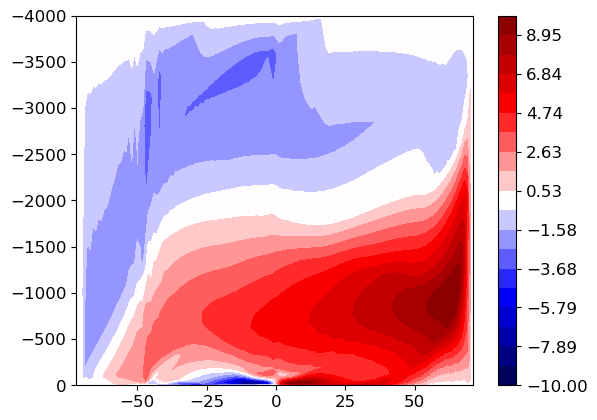

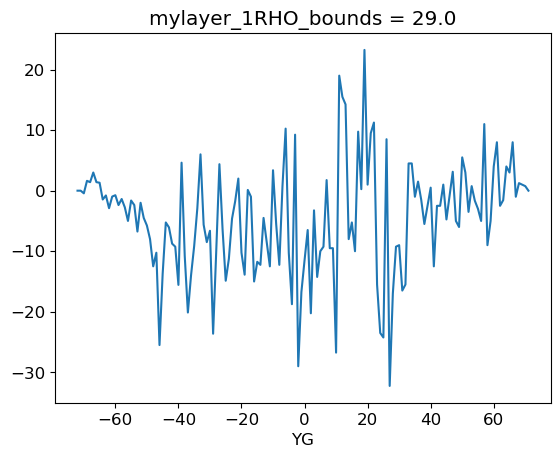

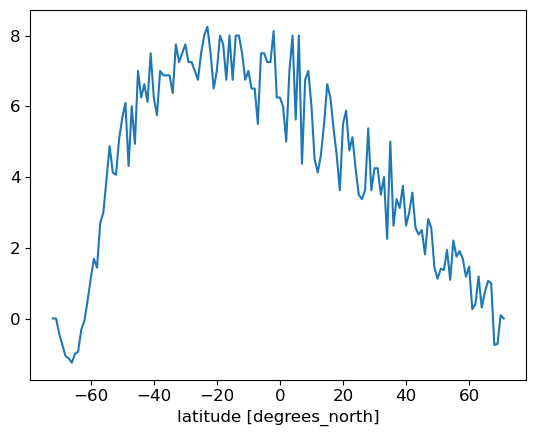

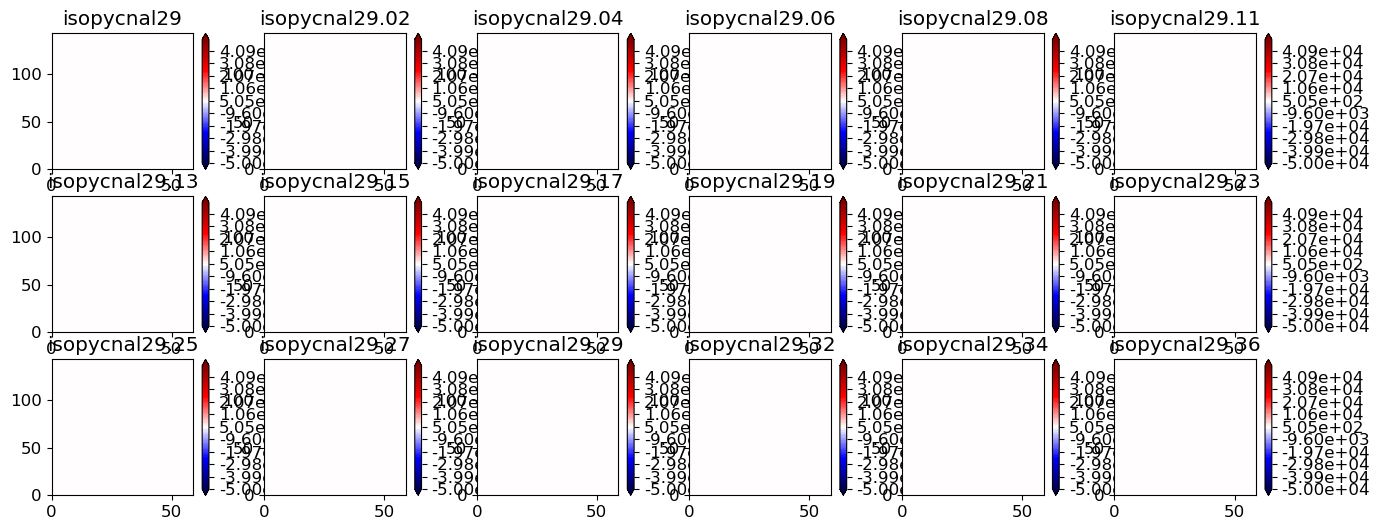

In [1147]:
plt.figure()
#tmpfVol.sum('Z').sum('XC').plot()
PsiX_layers_zonalsum[:,0].plot()
plt.figure()
(tmpfVoly.fillna(0)).sum('XC').sum('Z').plot()

PsiX_layers_grid=-dPsiX_layers[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
PsiY_layers_grid=-dPsiY_layers[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
dia_layers_3D=grid.diff(PsiX_layers_grid,'X',boundary='periodic')+grid.diff(PsiY_layers_grid,'Y')
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,6, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(dia_layers_3D[:,:,i],levels=np.linspace(-0.5e5,0.5e5,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal (Eul+gm) volume flux from xlayers package')

In [1146]:
XX.shape
YY.shape
ZZ.shape

(400, 144)

[[-72. -71. -70. ...  69.  70.  71.]
 [-72. -71. -70. ...  69.  70.  71.]
 [-72. -71. -70. ...  69.  70.  71.]
 ...
 [-72. -71. -70. ...  69.  70.  71.]
 [-72. -71. -70. ...  69.  70.  71.]
 [-72. -71. -70. ...  69.  70.  71.]]
[[ 0.00000000e+00  0.00000000e+00 -4.28263346e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.28263346e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.28263346e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00 -2.04367808e+03 ... -4.00000000e+03
  -4.00000000e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.25950020e+03 ... -4.00000000e+03
  -4.00000000e+03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.00000000e+03 ... -4.00000000e+03
  -4.00000000e+03  0.00000000e+00]]
[[-0.00000000e+00 -0.00000000e+00 -3.23699951e-07 ...  1.63793945e-06
   8.15519333e-07 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+

<xarray.Dataset>
Dimensions:               (time: 1, XC: 60, YC: 144, XG: 60, YG: 144, Z: 30,
                           Zp1: 31, Zu: 30, Zl: 30, layer_1RHO_bounds: 435,
                           layer_1RHO_center: 434, layer_1RHO_interface: 433)
Coordinates: (12/33)
    iter                  (time) int64 134308848
  * time                  (time) timedelta64[ns] 1554 days 12:00:48
  * XC                    (XC) >f4 0.5 1.5 2.5 3.5 4.5 ... 56.5 57.5 58.5 59.5
  * YC                    (YC) >f4 -71.5 -70.5 -69.5 -68.5 ... 69.5 70.5 71.5
  * XG                    (XG) >f4 0.0 1.0 2.0 3.0 4.0 ... 56.0 57.0 58.0 59.0
  * YG                    (YG) >f4 -72.0 -71.0 -70.0 -69.0 ... 69.0 70.0 71.0
    ...                    ...
    maskW                 (Z, YC, XG) bool False False False ... False False
    maskS                 (Z, YG, XC) bool False False False ... False False
    rhoRef                (Z) >f4 1.028e+03 1.028e+03 ... 1.044e+03 1.045e+03
  * layer_1RHO_bounds     (layer_1RHO_bounds) >f4 1.0 10.0 20.0 ... 37.99 38.0
  * layer_1RHO_center     (layer_1RHO_center) float32 5.5 15.0 ... 37.99 38.0
  * layer_1RHO_interface  (layer_1RHO_interface) >f4 10.0 20.0 ... 37.98 37.99
Data variables: (12/29)
    Ttave                 (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    wVeltave              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    vVeltave              (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    Tdiftave              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Kux                (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Kvy                (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    ...                    ...
    GM_Age_y              (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Age_r              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    Stave                 (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    GM_Kwz-T              (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    PTRtave01             (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
    uVeltave              (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 30, 144, 60), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=[1...

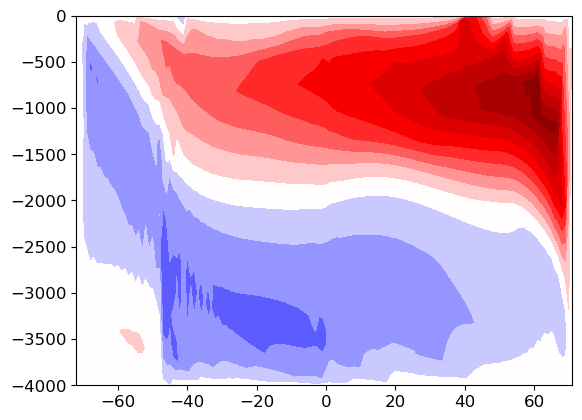

In [1141]:
#print()

XX=(0*PsiY_layers_zonalsum.T+dsGM2x.YG).load().data
YY=layer_depth.T
ZZ=(PsiY_layers_zonalsum.T/1e6).load().data
ZZ[np.isnan(YY)]=np.nan
YY[np.isnan(YY)]=0

#print(XX)
#print(YY)
#print(ZZ)
plt.contourf(XX.T,YY.T,ZZ.T,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
dsGM2x

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_4771/1285236313.py:50: RuntimeWarning: divide by zero encountered in true_divide
  age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_4771/1285236313.py:50: RuntimeWarning: invalid value encountered in true_divide
  age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds


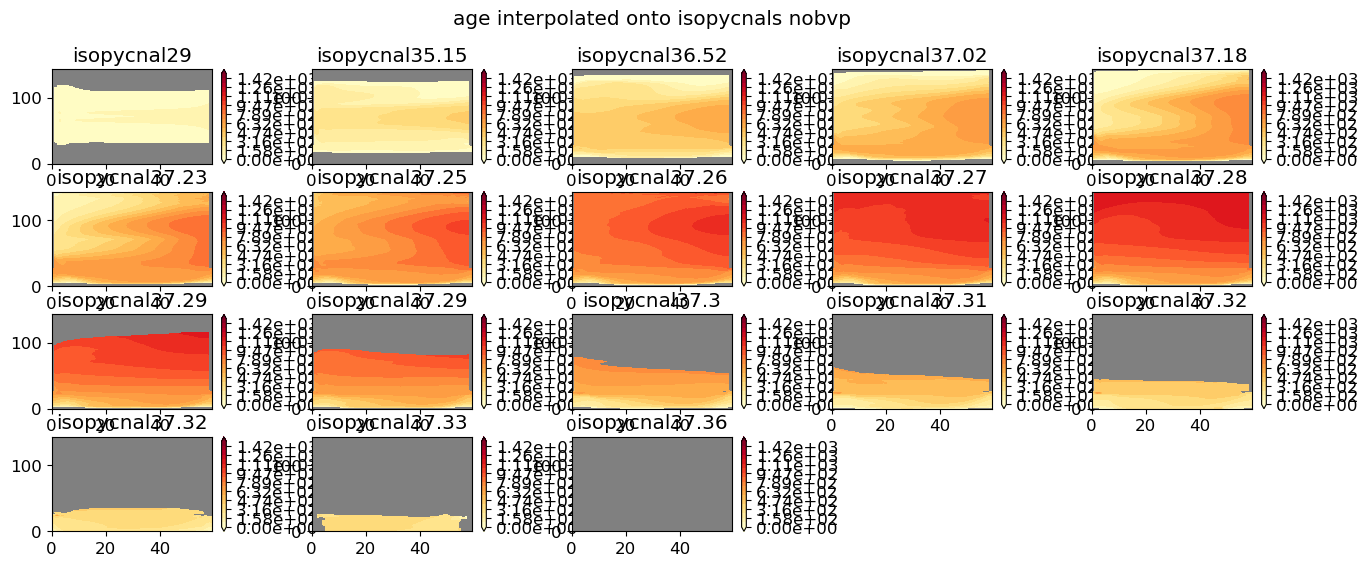

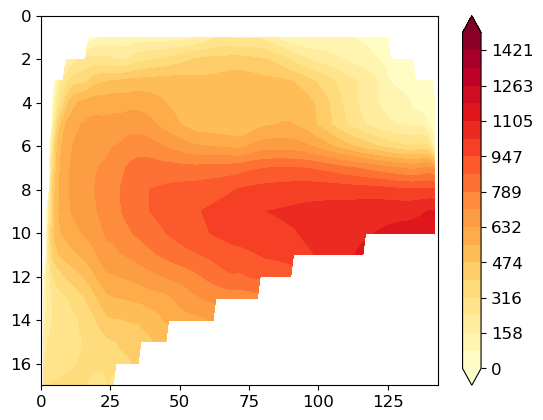

In [675]:
#top view of age interpolated to isopycnals

age=dsGM2x.PTRtave01
age=age.where(dsGM2x.maskC).mean('time')
agez_layers= layers_apply(age.fillna(0) ,(rho_nonan-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(rho_nonan-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
age_layers=(agez_layers/z_layers).load()

fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin):
    plt.subplot(4,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf((age_layers[:,:,i]/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('age interpolated onto isopycnals nobvp')
plt.figure()

age_layers_zonal=(agez_layers.sum('XC')/z_layers.sum('XC'))
'''
#plotting zonal mean age at layer center
plt.contourf((age_layers_zonal.T/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
plt.gca().invert_yaxis()
plt.title('zonal mean age at ')
'''


#interpolating age at the center of density layer to the boundary of density layers
agez_layers_np=agez_layers.load().data
z_layers_np=z_layers.load().data
agez_layers_np.shape
agez_layers_np_bounds=0*agez_layers_np
z_layers_np_bounds=0*z_layers_np
agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
#z_layers_np[z_layers_np==0]=np.nan
#z_layers_mask=0*z_layers_np
#z_layers_mask[:,:,0]=z_layers_np[:,:,0]
#z_layers_mask[:,:,1:]=z_layers_np[:,:,1:]*z_layers_np[:,:,0:-1]
#z_layers_mask[z_layers_mask!=0]=1
#print("z_layers_mask:",z_layers_mask)
z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
#agez_layers_np_bounds=agez_layers_np_bounds
#z_layers_np_bounds=z_layers_np_bounds
age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
age_layers_np_bounds[age_layers_np_bounds==0]=np.nan
#print(age_layers_np_bounds)
'''
#plotting top view of age interpolated to boundary of density layers
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf((age_layers_np_bounds[:,:,i]/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('age interpolated onto isopycnals nobvp')
'''

#agez_layers_np_bounds=
#agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
agez_layers_bounds_zonal=agez_layers_np_bounds_xr.sum('XC')/z_layers_np_bounds_xr.sum('XC')
age_layers_zonal=(agez_layers.sum('XC')/z_layers.sum('XC'))
##

plt.contourf((agez_layers_bounds_zonal.T/31104000),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
#plt.pcolor((agez_layers_bounds_zonal.T/31104000),cmap=plt.cm.YlOrRd,vmin=0,vmax=1500)

plt.gca().invert_yaxis()
plt.colorbar()



In [735]:
rA=dsGM2x.rA.copy()
#(((z_layers.where(z_layers!=0)*rA.where(z_layers!=0)).sum('XC').sum('YC'))/((rA).sum('XC').sum('YC'))).sum('mylayer_1RHO_bounds')
depth_layers_bottom=z_layers.cumsum('mylayer_1RHO_bounds')
#depth_layers_bottom

volbelow
np.linspace(-10,10,20)

array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
        -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
        -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
         2.63157895,   3.68421053,   4.73684211,   5.78947368,
         6.84210526,   7.89473684,   8.94736842,  10.        ])

slice(7, 18, None)


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in multiply
  result_data = func(*input_data)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


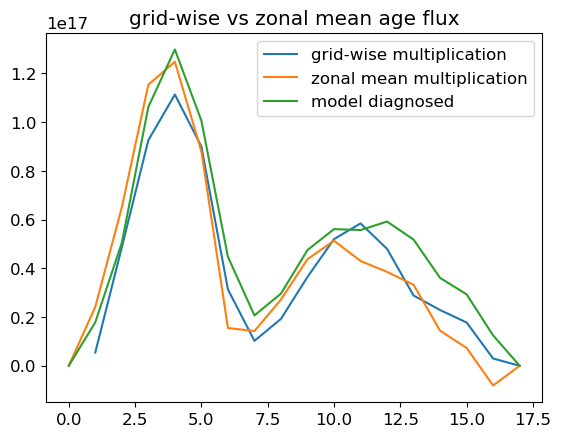

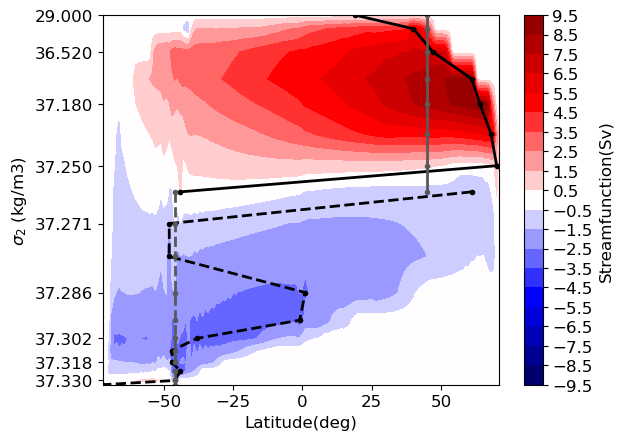

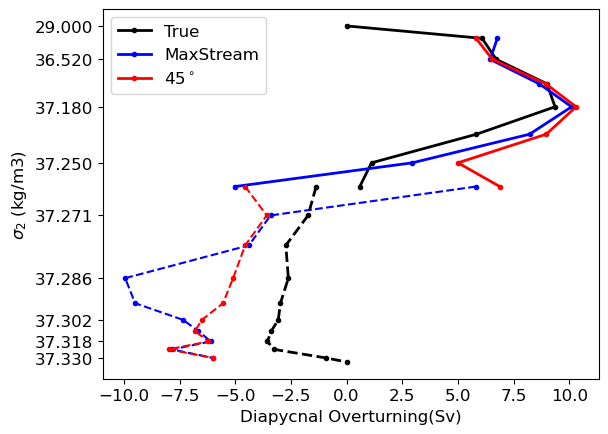

In [746]:
##calculating grid-wise total age flux
ageflux_layers3D=age_layers_np_bounds*dia_layers_3D
ageflux_layers3D=ageflux_layers3D.fillna(0)
totageflux_layers=ageflux_layers3D.sum('XC').sum('YC')
dia_layers_3D_zonal=dia_layers_3D.sum('XC')
totageflux_layers_zonalmul=(dia_layers_3D_zonal*age_layers_zonal).sum('YC')

#plotting grid-wise total age flux
totalageflux_inverted=0*totageflux_layers
totalageflux_inverted[:-1]=sumdivGM_rho+sumdivadv_rho
plt.plot(totageflux_layers,label='grid-wise multiplication')
plt.plot(totageflux_layers_zonalmul,label='zonal mean multiplication')
plt.plot(totalageflux_inverted,label='model diagnosed')
plt.legend()
plt.title('grid-wise vs zonal mean age flux')

volbelow=np.zeros(Nlayersbin)
volbelow[0:-1]=sumVol_rho


plt.figure()
#plt.subplot(1,2,1)
plt.contourf(dsGM2x.YG,volbelow, PsiX_layers_zonalsum.T/1e6,levels=np.linspace(-9.5,9.5,20),vmin=-10,vmax=10,cmap='seismic')
#plt.pcolor(dsGM2x.YG,volbelow, PsiX_layers_zonalsum.T/1e6,vmin=-10,vmax=10,cmap='seismic')

#plt.gca().invert_yaxis()

maxidsarg=PsiX_layers_zonalsum.argmax('YG')
minidsarg=PsiX_layers_zonalsum.argmin('YG')
maxlats=dsGM2x.YG[maxidsargmax]
minlats=dsGM2x.YG[minidsargmin]
streamflux_upper=PsiX_layers_zonalsum.max('YG')/1e6
streamflux_lower=PsiX_layers_zonalsum.min('YG')/1e6
slice_up=slice(0,8)
slice_down=slice(7,Nlayersbin)
plt.plot(maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
print(slice_down)
plt.plot(minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)


#YGindex=0*dsGM2x.YG+np.arange(len(dsGM2x.YG))


latidxr=xr.ones_like(agez_layers_np_bounds_xr)
latidxr=latidxr.cumsum('YC')-1
maxidslat40=(latidxr.mean('XC').sel(YC=45.5)).astype(int)
minidslat40=(latidxr.mean('XC').sel(YC=-45.5)).astype(int)
maxlats=dsGM2x.YG[maxidslat40]
minlats=dsGM2x.YG[minidslat40]
plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.35',linewidth=2)
plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.35',linewidth=2)
plt.xlabel('Latitude(deg)')
plt.ylabel('$\sigma_2$ (kg/m3)')
plt.colorbar(ticks=np.linspace(-9.5,9.5,20),label='Streamfunction(Sv)')
plt.clim(-10,10)
ylabels_layer= [f"{x:.3f}" for x in layers1_bounds[::2]]
plt.yticks(volbelow[::2], ylabels_layer)

#plt.plot(sumdivadv_rho,'.-',label='advflux')
#ageflux_layers3D=dia_layers_3D*0+ageflux_layers3D_np
plt.figure()


plt.plot(streamflux_upper[slice_up],volbelow[slice_up],'.-k',linewidth=2,label='True')
plt.plot(streamflux_lower[slice_down],volbelow[slice_down],'.--k',linewidth=2)

slice_up=slice(1,8)
slice_down=slice(7,Nlayersbin-1)
##
upmask=latidxr<PsiX_layers_zonalsum.argmax('YG')
downmask=latidxr>=PsiX_layers_zonalsum.argmax('YG')

rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
#print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
#print("upage:",upage_area)
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'.-b',linewidth=2,label='MaxStream')

##
upmask=latidxr>=PsiX_layers_zonalsum.argmin('YG')
downmask=latidxr<PsiX_layers_zonalsum.argmin('YG')
rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'.--b')
##
upmask=latidxr<maxidslat40
downmask=latidxr>=maxidslat40
rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'.-r',linewidth=2,label='45$^\circ$')
#print((downage_area))

upmask=latidxr>=minidslat40
downmask=latidxr<minidslat40

rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'.--r')
ylabels_layer= [f"{x:.3f}" for x in layers1_bounds[::2]]
plt.yticks(volbelow[::2], ylabels_layer)
#plt.gca().invert_yaxis()
plt.xlabel('Diapycnal Overturning(Sv)')
plt.ylabel('$\sigma_2$ (kg/m3)')
plt.legend()

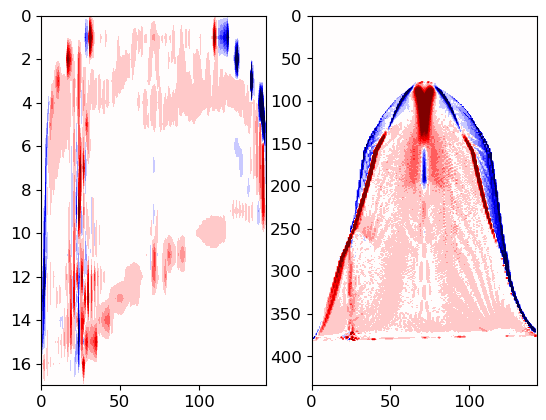

In [571]:
plt.subplot(1,2,1)
dia_xlayers=grid.diff(PsiX_layers_zonalsum,'Y')/dsGM2x.dyG[:,0]
plt.contourf(dia_xlayers.T,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,extend='both',cmap='seismic')
#plt.contourf(dia_xlayers.T,cmap='seismic')
#PsiX_layers_zonalsum
#plt.colorbar()
plt.gca().invert_yaxis()
dia_xlayers
plt.subplot(1,2,2)
varpi = ((grid.diff(grid.cumsum(dsGM2xADVForm.LaUH1RHO,'1RHO',boundary='fill')*dsGM2xADVForm.dyG, 'X',boundary='periodic') + 
             grid.diff(grid.cumsum(dsGM2xADVForm.LaVH1RHO,'1RHO',boundary='fill')*dsGM2xADVForm.dxG, 'Y',boundary='fill'))
          / grid.interp(dsGM2xADVForm.dyG,'X',boundary='fill')).sum('XC')
varpi=varpi.mean('time')
plt.contourf(varpi,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,extend='both',cmap='seismic')
#varpi.plot.contourf(levels=np.linspace(-10,10,20),vmin=-10,vmax=10,extend='both',cmap='seismic')
plt.gca().invert_yaxis()
######ROC
ROC1=grid.cumsum((dsGM2xADVForm.LaVH1RHO*dsGM2xADVForm.dxG).mean('time').sum('XC'),'1RHO',boundary='fill').load()

plt.contourf(ROC1/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
plt.colorbar()
plt.gca().invert_yaxis()


ValueError: num must be 1 <= num <= 15, not 16

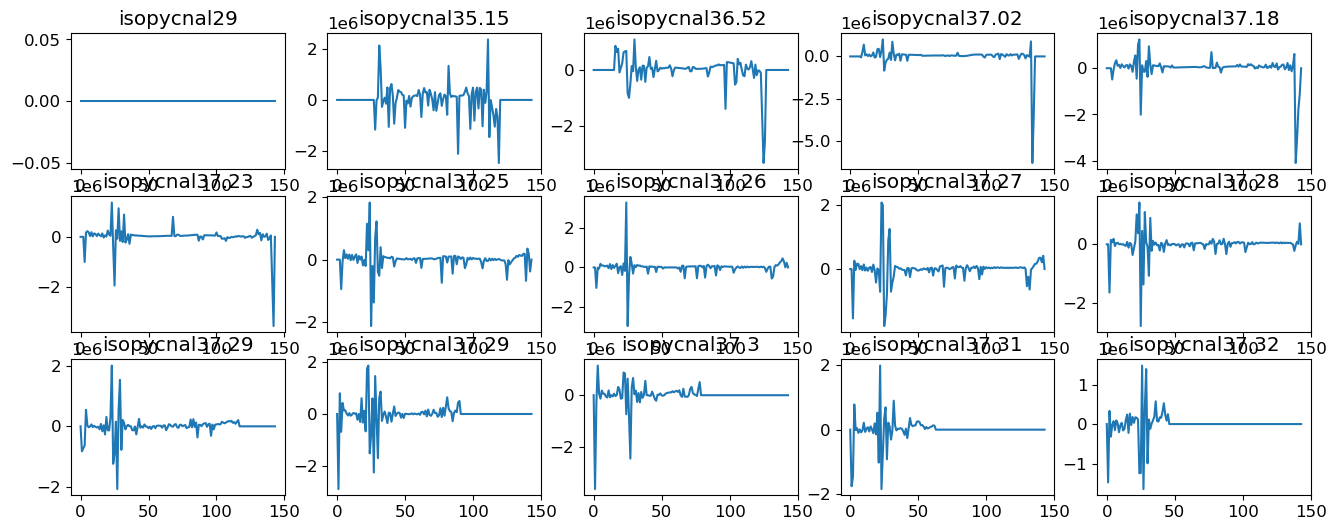

In [573]:
'''
diaVoladvnobvp_zonalsum=np.sum(diaVoladvnobvp,axis=2)
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    plt.plot(diaVoladvnobvp_zonalsum[i,:])
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    #plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal age advection transport(Euler+gm)')
'''


In [ ]:
fig = plt.figure(figsize=(16,6))
diaVoladvEufluxrhotemp=diaageadvgmfluxrho.copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e15,0.5e15,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal age advection transport(gm)')
fig = plt.figure(figsize=(16,6))
diaVoladvEufluxrhotemp=diaageadvEufluxrho.copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e15,0.5e15,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal age advection transport(Eulerian)')
fig = plt.figure(figsize=(16,6))
diaVoladvEufluxrhotemp=diaageadvfluxrho.copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e15,0.5e15,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal age advection transport(Eulerian+gm)')




In [ ]:
agetmean=diaagerho_nobvp.copy()/31104000
agetmean[agetmean==0]=np.nan
#agetmean[diaVoladvfluxrho<=1e-20]=np.nan
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(agetmean[i,:,:],cmap=plt.cm.YlOrRd,levels=np.linspace(0,1500,20),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('age interpolated onto isopycnals nobvp')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
diaVoladvEufluxrhotemp=diaVoladvEufluxrho.copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e5,0.5e5,20),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal Volume transport(Eulerian)')

fig = plt.figure(figsize=(16,6))
diaVoladvfluxrhotemp=diaVoladvgmfluxrho.copy()
diaVoladvfluxrhotemp[diaVoladvfluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvfluxrhotemp[i,:,:],levels=np.linspace(-0.5e5,0.5e5,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal Volume transport(gm)')
fig = plt.figure(figsize=(16,6))
diaVoladvEufluxrhotemp=(diaVoladvEufluxrho+diaVoladvgmfluxrho).copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e5,0.5e5,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal Volume transport(Eulerian+gm)')
fig = plt.figure(figsize=(16,6))
diaVoladvEufluxrhotemp=(diaVoladvnobvp).copy()
diaVoladvEufluxrhotemp[diaVoladvEufluxrhotemp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diaVoladvEufluxrhotemp[i,:,:],levels=np.linspace(-0.5e5,0.5e5,100),cmap='seismic',extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey") 
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycnal Volume transport(Eulerian+gm nobvp)')


In [ ]:
fig = plt.figure(figsize=(10,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diafluxrho3D[i,:,:],cmap='seismic',levels=np.linspace(-0.5e16,0.5e16,10))
    plt.colorbar()
    plt.title(f"depth{np.sum(diafluxrho3D[i,:,:]):.2g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:


fdia_my=-kdia3d*agezgrad.fillna(0)*dsGM2x.rA
diadiffflux3D=diaFluxOnRho_3D(fx=0*fdia.load().data,fy=0*fdia.load().data,fz=fdia_my.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
ax=plt.plot(diadiffflux_hsum,layers1_bounds[0:Nlayersbin-1])

plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()
#agezgrad
#fdia
diadiffflux3D=diaFluxOnRho_3D(fx=0*fdia.load().data,fy=0*fdia.load().data,fz=fdia.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
ax=plt.plot(diadiffflux_hsum,layers1_bounds[0:Nlayersbin-1])


plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()
agezgrad_rA=agezgrad*dsGM2x.rA
agezgrad_rA=agezgrad_rA.fillna(0)
diasum_agezgrad_rA_3D=diaFluxOnRho_3D(fx=0*agezgrad_rA.load().data,fy=0*agezgrad_rA.load().data,fz=agezgrad_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
diasum_agezgrad_rA_3D_hsum=np.sum(np.sum(diasum_agezgrad_rA_3D,axis=2),axis=1)
#effect_kdia=diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
plt.plot(diasum_agezgrad_rA_3D_hsum,layers1_bounds[0:Nlayersbin-1])
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()


In [ ]:
kdia_infer_diainterp_2D=-diadiffflux3D/(diasum_agezgrad_rA_3D+1e-20)
kdia_infer_diainterp_2D_hsum=np.mean(np.mean(kdia_infer_diainterp_2D,axis=2),axis=1)
kdia_infer_diainterp=-diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
kdia3d_rA=kdia3d*dsGM2x.rA
rA3d=0*kdia3d+dsGM2x.rA
kdia_rA_diainterp=diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
rA_diainterp=diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
kdia_diainterp=kdia_rA_diainterp/(rA_diainterp+1e-20)
'''
This line below does not look perfectly correct,when calculating mean value,
the extra 0 values should be masked. On the other hand, 
the 0 values are not a great concern when doing sum.
'''

#Mask_kdia_diainterp=(kdia_diainterp!=0)
kdia_diainterp_hsum=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/(np.sum(np.sum(rA_diainterp+1e-30,axis=2),axis=1))

plt.plot(kdia_diainterp_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o-')
plt.plot(kdia_infer_diainterp[1:],layers1_bounds[1:Nlayersbin-1],'.--')
#plt.plot(kdia_infer_diainterp_2D_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o')

plt.xlabel('kdia')
plt.ylabel('density surfaces')
plt.gca().invert_yaxis()

In [ ]:
fig = plt.figure(figsize=(16,6))
kdia_diainterp[kdia_diainterp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(kdia_diainterp[i,:,:],levels=np.linspace(0,1e-4,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('kdia isopycanl mean')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
diadiffflux3D[diadiffflux3D==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diadiffflux3D[i,:,:],cmap='seismic',levels=np.linspace(-5e13,5e13,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")
    
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycanl diffusive flux on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diasum_agezgrad_rA_3D[i,:,:],cmap='seismic',levels=np.linspace(-4e17,4e17,10),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('agezgrad*rA on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
'''
age=dsGM2x.PTRtave01
age=age.where(age!=0)
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    #im=(agel).where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e4,add_colorbar=False,extend='neither')
    im=(PsixGM_Tensor).isel(Zl=i).plot.contourf(levels=np.linspace(-1.8,1.8,20),add_colorbar=False,extend='neither',cmap='seismic')

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='GM_PsiX_fromTensor')
age=dsGM2x.PTRtave01
age=age.where(age!=0)
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    #im=(agel).where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e4,add_colorbar=False,extend='neither')
    im=(GM_PsiX_nobvp-PsixGM_Tensor).isel(Zl=i).plot.contourf(levels=np.linspace(-1.8,1.8,20),add_colorbar=False,extend='neither',cmap='seismic')

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='GM_PsiX_diagnosed_nobvp-GM_PsiX_fromTensor')
age=dsGM2x.PTRtave01
age=age.where(age!=0)
#age at Zl
agel=grid.interp(age, 'Z',boundary='fill')
fig = plt.figure(figsize=(10,12))
for i in range(0,30):
    plt.subplot(6,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=dsGM2x.W.where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False)
    #im=(agel).where(dsGM2x.W!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e4,add_colorbar=False,extend='neither')
    im=(GM_PsiX_nobvp).isel(Zl=i).plot.contourf(levels=np.linspace(-1.8,1.8,20),add_colorbar=False,extend='neither',cmap='seismic')

    #plt.colorbar()
    plt.title("depth"+str(dsGM2x.Zl[i].data))
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='GM_PsiX_diagnosed_nobvp')
'''
1

In [ ]:
agetmean=diaagerho/31104000
wVolumetmean=diaVoladvfluxrho.copy()
wVolumepos=wVolumetmean.copy()
wVolumepos[wVolumetmean<=0]=0
wVolumeneg=wVolumetmean.copy()
wVolumeneg[wVolumetmean>=0]=0
agepos=agetmean.copy()
agepos[wVolumetmean<=0]=0
ageneg=agetmean.copy()
ageneg[wVolumetmean>=0]=0
#wVolumeneg=wVolumetmean[wVolumetmean<0]
#ageneg=agetmean[wVolumetmean<0]

#agepos_areamean=grid.average(agepos,['X','Y'])
#ageneg_areamean=grid.average(ageneg,['X','Y'])
'''
agepos_fluxmean=grid.average(agepos*wVolumepos,['X','Y'])/grid.average(wVolumepos,['X','Y'])
ageneg_fluxmean=grid.average(ageneg*wVolumeneg,['X','Y'])/grid.average(wVolumeneg,['X','Y'])
deltaage_flux=-(ageneg_fluxmean-agepos_fluxmean)
deltaage_area=-(ageneg_areamean-agepos_areamean)
agepos_areamean.plot(y='Zl',label='ageup_area')
agepos_fluxmean.plot(y='Zl',label='ageup_flux')
ageneg_areamean.plot(y='Zl',label='agedown_area')
ageneg_fluxmean.plot(y='Zl',label='agedown_flux')
deltaage_flux.plot(y='Zl',label='deltaage_flux')
deltaage_area.plot(y='Zl',label='deltaage_area')
plt.legend()
'''
#diaVoladvfluxrho_hsum=np.sum(np.sum(wVolumeneg,axis=2),axis=1)
#diaVoladvfluxrho_hsum

In [ ]:
plt.plot(sumdivdia_rho,np.r_[0:Nlayersbin-1],label='dia flux')
plt.plot(diadiffflux_hsum,np.r_[0:Nlayersbin-1],'o',label='dia flux')

sumdivdia_rho
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()

In [ ]:
divtot_rhosum=divtot_rho.sum('XC').sum('YC')
divtot_rhosum=divtot_rhosum[::-1].cumsum('rho_coord')[::-1]
Vol_rhosum=Vol_rho.sum('XC').sum('YC')
Vol_rhosum=Vol_rhosum[::-1].cumsum('rho_coord')[::-1]
fsurf_rhosum=fsurf_rho.sum('XC').sum('YC')
fsurf_rhosum=fsurf_rhosum[::-1].cumsum('rho_coord')[::-1]
divtot_rhosum.plot()
Vol_rhosum.plot()
(divtot_rhosum-fsurf_rhosum).plot()

In [ ]:
divconv